In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.font_manager as fm
font_path = '/users/wanglikun/.local/share/fonts/arial.ttf'  
fm.fontManager.addfont(font_path)                            
arial_name = fm.FontProperties(fname=font_path).get_name()  
plt.rcParams['font.family'] = [arial_name]
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv("dataset/data.csv", low_memory = False)
df["label"] = df["label"].replace({r"\b(PEPH|NaPE)\b": "PE", r"\b(peph)\b": "pe"}, regex = True)
df["label"] = df["label"].str.strip()

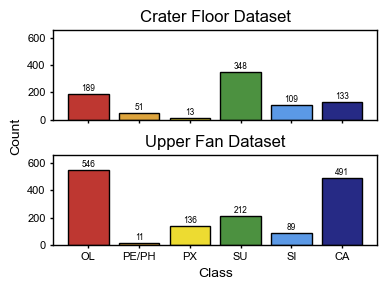

In [3]:
subset1 = df.iloc[:2000].copy()
subset2 = df.iloc[2000:].copy()

mapping = {"su": "SU", "ol": "OL", "ca": "CA", "si": "SI", "pe": "PE/PH", "px": "PX"}

def preprocess(subset):
    labels = subset["label"].astype(str).str.lower().str.strip()
    base_group = labels.map(mapping)
    subset = subset.copy()
    subset["label_group"] = base_group
    subset = subset.dropna(subset=["label_group"])
    return subset

subset1 = preprocess(subset1)
subset2 = preprocess(subset2)
order_A = ["OL", "PE/PH", "PX", "SU", "SI", "CA"]
order_C = ["OL", "PE/PH", "PX", "SU", "SI", "CA"]
counts1 = subset1["label_group"].value_counts().reindex(order_A, fill_value=0)
counts2 = subset2["label_group"].value_counts().reindex(order_C, fill_value=0)

color_pair = {
    "OL":    ("#DE9B98", "#BE3731"),
    "PE/PH": ("#EED19E", "#DDA43D"),
    "PX":    ("#F6ED98", "#EDDB31"),
    "SU":    ("#A5C89F", "#4C9140"),
    "SI":    ("#ADCBF3", "#5B99E6"),
    "CA":    ("#9294C2", "#262A85")
}

colors_cf = [color_pair[c][1] for c in order_A]
colors_uf = [color_pair[c][1] for c in order_C]

ymax = max(counts1.max(), counts2.max()) * 1.2

fig, axes = plt.subplots(2, 1, figsize=(3.8, 3), sharex=False)

axes[0].bar(order_A, counts1, color=colors_cf, edgecolor="black")
axes[0].set_ylabel("")
axes[0].set_title("Crater Floor Dataset", fontsize=12)
axes[0].set_ylim(0, ymax)
axes[0].tick_params(axis="both", which="both", width=1, length=2, labelsize=8)
axes[0].set_xticklabels([])

for i, v in enumerate(counts1):
    if v > 0:
        axes[0].text(i, v + ymax * 0.01, str(int(v)), ha="center", va="bottom", fontsize=6)

axes[1].bar(order_C, counts2, color=colors_uf, edgecolor="black")
axes[1].set_ylabel("")
axes[1].set_title("Upper Fan Dataset", fontsize=12)
axes[1].set_ylim(0, ymax)
axes[1].tick_params(axis="both", which="both", width=1, length=2, labelsize=8)
for i, v in enumerate(counts2):
    if v > 0:
        axes[1].text(i, v + ymax * 0.01, str(int(v)), ha="center", va="bottom", fontsize=6)

for ax in axes:
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_linewidth(1)
    ax.tick_params(axis="both", which="both", width=1, length=2)

fig.text(0.01, 0.53, "Count", ha="center", va="center", rotation="vertical", fontsize=10)
plt.xlabel("Class", fontsize=10)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4) 
plt.savefig("figure/2a.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [4]:
def get_acc(csv_path, col_name):
    data = pd.read_csv(csv_path)
    data["true"] = data["true"].str.upper()
    df_test = data[data["split"] == "test"].copy()
    results = []
    for run_id in sorted(df_test["run"].unique()):
        df_run = df_test[df_test["run"] == run_id]
        results.append(accuracy_score(df_run["true"], df_run["pred"]))
    return pd.Series(results, name=col_name)

result_A2A = pd.read_csv("dataset/A2A_ML.csv")
result_A2A.columns = ["rs", "KNN", "SVM", "RF"]
result_A2A["1D-CNN"]      = get_acc("dataset/A2A_CNN.csv", "CNN")
result_A2A["DSCARNet"] = get_acc("dataset/A2A.csv", "DSCARNet")

result_C2C = pd.read_csv("dataset/C2C_ML.csv")
result_C2C.columns = ["rs", "KNN", "SVM", "RF"]
result_C2C["1D-CNN"]      = get_acc("dataset/C2C_CNN.csv", "CNN")
result_C2C["DSCARNet"] = get_acc("dataset/C2C.csv", "DSCARNet")

long_A2A = result_A2A.melt(id_vars="rs", var_name="Algorithm", value_name="Accuracy")
long_C2C = result_C2C.melt(id_vars="rs", var_name="Algorithm", value_name="Accuracy")

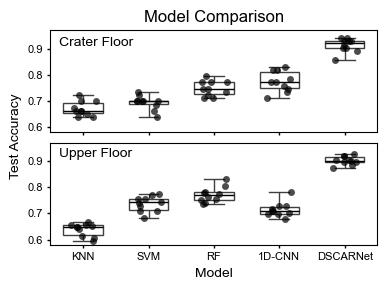

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(3.8,3), sharex=True)

# --- A2A ---
sns.boxplot(
    x="Algorithm", y="Accuracy",
    data=long_A2A, width=0.6, whis=[0, 100],
    boxprops={"facecolor": "none"}, whiskerprops={"linewidth": 1},
    capprops={"linewidth": 1}, medianprops={"color": "black", "linewidth": 1},
    showfliers=True, ax=axes[0]
)
sns.stripplot(
    x="Algorithm", y="Accuracy",
    data=long_A2A, color="black", size=5,
    jitter=0.2, alpha=0.7, ax=axes[0]
)
axes[0].set_title("Model Comparison", fontsize=12)
axes[0].set_ylabel("")
axes[0].set_ylim(0.58, 0.97)
axes[0].tick_params(axis="both", which="both", width=1, length=2, labelsize=8)

# --- C2C ---
sns.boxplot(
    x="Algorithm", y="Accuracy",
    data=long_C2C, width=0.6, whis=[0, 100],
    boxprops={"facecolor": "none"}, whiskerprops={"linewidth": 1},
    capprops={"linewidth": 1}, medianprops={"color": "black", "linewidth": 1},
    showfliers=True, ax=axes[1]
)
sns.stripplot(
    x="Algorithm", y="Accuracy",
    data=long_C2C, color="black", size=5,
    jitter=0.2, alpha=0.7, ax=axes[1]
)
axes[1].set_ylabel("")
axes[1].set_xlabel("Model", fontsize=10)
axes[1].set_ylim(0.58, 0.97)
axes[1].tick_params(axis="both", which="both", width=1, length=2, labelsize=8)

fig.text(0.01, 0.53, "Test Accuracy", ha="center", va="center", rotation="vertical", fontsize=10)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
fig.text(0.22, 0.84, "Crater Floor", ha="center", va="center", fontsize=10) 
fig.text(0.22, 0.47, "Upper Floor", ha="center", va="center", fontsize=10)
plt.savefig("figure/2c.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

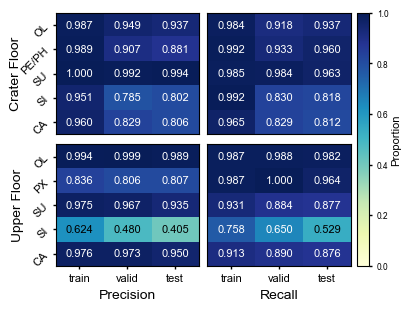

In [6]:
def get_PR(file, order):
    df = pd.read_csv(file)
    df["true"] = df["true"].str.upper().replace("PE", "PE/PH")
    df["pred"] = df["pred"].str.upper().replace("PE", "PE/PH")
    rows = []
    for (run_id, split), df_run in df.groupby(["run", "split"]):
        cm = confusion_matrix(df_run["true"], df_run["pred"], labels = order)
        TP = np.diag(cm)
        FP = cm.sum(axis=0) - TP
        FN = cm.sum(axis=1) - TP
        precision = np.divide(TP, TP + FP, out=np.zeros_like(TP, float), where=(TP+FP)!=0)
        recall    = np.divide(TP, TP + FN, out=np.zeros_like(TP, float), where=(TP+FN)!=0)
        for i, cls in enumerate(order):
            rows.append({
                "run": run_id,
                "split": split,
                "class": cls,
                "precision": precision[i],
                "recall": recall[i]
            })
    df_result = pd.DataFrame(rows)
    summary = (df_result.groupby(["split", "class"])[["precision","recall"]]
               .agg(["mean","std"])
               .reset_index())   
    return summary
    
def get_PR2(PR, order):
    pr_idx = PR.set_index(["class", "split"]).sort_index()
    P_ = pr_idx["precision"]["mean"].unstack("split")\
                .reindex(index=order, columns=splits).to_numpy()
    R_ = pr_idx["recall"]["mean"].unstack("split")\
                .reindex(index=order, columns=splits).to_numpy()
    return P_, R_
    
file_A = "dataset/A2A.csv"
file_C = "dataset/C2C.csv"
order_A = ["OL", "PE/PH", "SU", "SI", "CA"]
order_C = ["OL", "PX", "SU", "SI", "CA"]
PR_A = get_PR(file_A, order_A)
PR_C = get_PR(file_C, order_C)
splits = ["train", "valid", "test"]
P_A, R_A = get_PR2(PR_A, order_A)
P_C, R_C = get_PR2(PR_C, order_C)

fig, axes = plt.subplots(2, 2, figsize=(4, 3), constrained_layout=True)

def plot_heat(ax, mat, title, xlabels, ylabels):
    im = ax.imshow(mat, aspect="auto", vmin=0.0, vmax=1.0, cmap="YlGnBu")
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_xticklabels(xlabels, fontsize=6)
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_yticklabels(ylabels, fontsize=6, rotation=45)
    ax.tick_params(axis="y", pad=2)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            v = mat[i, j]
            ax.text(j, i, f"{v:.3f}",
                    ha="center", va="center",
                    color=("white" if v >= 0.65 else "black"),
                    fontsize=8)
    return im

#A Precision
im1 = plot_heat(axes[0,0], P_A, "", splits, order_A)
axes[0,0].set_xlabel("")      
axes[0,0].set_xticks([])     
axes[0,0].set_ylabel("Crater Floor", fontsize=10, labelpad=-2)
#A Recall
im2 = plot_heat(axes[0,1], R_A, "", splits, order_A)
axes[0,1].set_xlabel("")      
axes[0,1].set_xticks([])
axes[0,1].set_ylabel("")      
axes[0,1].set_yticks([])

#C Precision
im3 = plot_heat(axes[1,0], P_C, "", splits, order_C)
axes[1,0].set_xlabel("Precision", fontsize=10)
axes[1,0].set_xticks(np.arange(len(splits)))
axes[1,0].set_xticklabels(splits)
axes[1,0].set_ylabel("Upper Floor", fontsize=10, labelpad=6)

#C Recall
im4 = plot_heat(axes[1,1], R_C, "", splits, order_C)
axes[1,1].set_xlabel("Recall", fontsize=10)
axes[1,1].set_xticks(np.arange(len(splits)))
axes[1,1].set_xticklabels(splits)
axes[1,1].set_ylabel("")
axes[1,1].set_yticks([])

cbar = fig.colorbar(im4, ax=axes.ravel().tolist(), fraction=1, pad=0.02)
cbar.set_label("Proportion", fontsize=8, labelpad=2)
cbar.ax.tick_params(labelsize=6)
cbar.ax.tick_params(which="both", width=1, length=2)

for ax in axes.ravel():
    ax.tick_params(axis="x", labelsize=8)   
    ax.tick_params(axis="y", labelsize=8)   
    
    ax.tick_params(axis="both", which="both",  
                   direction="out",            
                   length=2, width=1,       
                   colors="black")           

plt.savefig("figure/2d.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

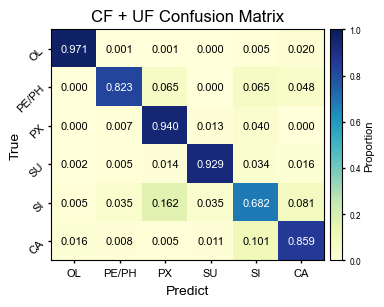

In [7]:
def get_test(file):
    data = pd.read_csv(file)
    df_test = data[data["split"]=="test"].copy()
    df_test["true"] = df_test["true"].str.upper()
    df_test["pred"] = df_test["pred"].str.upper()
    df_test["true"] = df_test["true"].replace("PE", "PE/PH")
    df_test["pred"] = df_test["pred"].replace("PE", "PE/PH")
    return df_test
    
def get_matrix(df_test, order):
    cm_sum = np.zeros((len(order), len(order)), dtype=float)
    n_runs = df_test["run"].nunique()
    for run_id, df_run in df_test.groupby("run"):
        cm = confusion_matrix(df_run["true"], df_run["pred"], labels=order)
        cm_sum += cm
    cm_avg = cm_sum / n_runs
    cm_norm = cm_avg / cm_avg.sum(axis=1, keepdims=True)
    return cm_norm

def plot_heat(ax, mat, title, xlabels, ylabels):
    im = ax.imshow(mat, aspect="auto", vmin=0.0, vmax=1.0, cmap="YlGnBu")
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_xticklabels(xlabels, fontsize=8)
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_yticklabels(ylabels, fontsize=8, rotation=45, ha="right")
    ax.tick_params(axis="y", pad=2)
    ax.set_title(title, fontsize=12)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            v = mat[i, j]
            ax.text(j, i, f"{v:.3f}",
                    ha="center", va="center",
                    color=("white" if v >= 0.65 else "black"),
                    fontsize=8)
    return im

df_test_AC2AC = get_test("dataset/AC2AC.csv")
order = ["OL", "PE/PH", "PX", "SU", "SI", "CA"]
cm_AC2AC = get_matrix(df_test_AC2AC, order)

fig, ax = plt.subplots(figsize=(4, 3))

im1 = plot_heat(ax, cm_AC2AC, "CF + UF Confusion Matrix", order, order)
ax.set_ylabel("True", fontsize=10, labelpad=-5)
ax.set_xlabel("Predict", fontsize=10, labelpad=5)

cbar = fig.colorbar(im1, ax=ax, orientation="vertical", fraction=0.1, pad=0.02)
cbar.set_label("Proportion", fontsize=8, labelpad=2)
cbar.ax.tick_params(labelsize=6)
cbar.ax.tick_params(which="both", width=1, length=2)

ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.tick_params(axis="both", which="both",
               direction="out", length=2, width=1, colors="black")

plt.savefig("figure/2e.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()